Voice Activity Detection Model 

Name: P.A. Hasith Vikasitha Dharmarathna
ID: 20223265
Course: 6COSC020W Applied AI 

Part A - Application Area Review

In [1]:
## TODO

Part B - Compare and Evaluate AI Techniques

In [2]:
## TODO

### Part C - Implementation


For this implementation, a Bidirectional Long Short-Term Memory (BiLSTM) deep learning model was selected for Voice Activity Detection (VAD). This technique was chosen because BiLSTM networks are effective for time-series audio data and can learn temporal speech patterns such as speech continuity and pauses.

## High-Level System Diagram


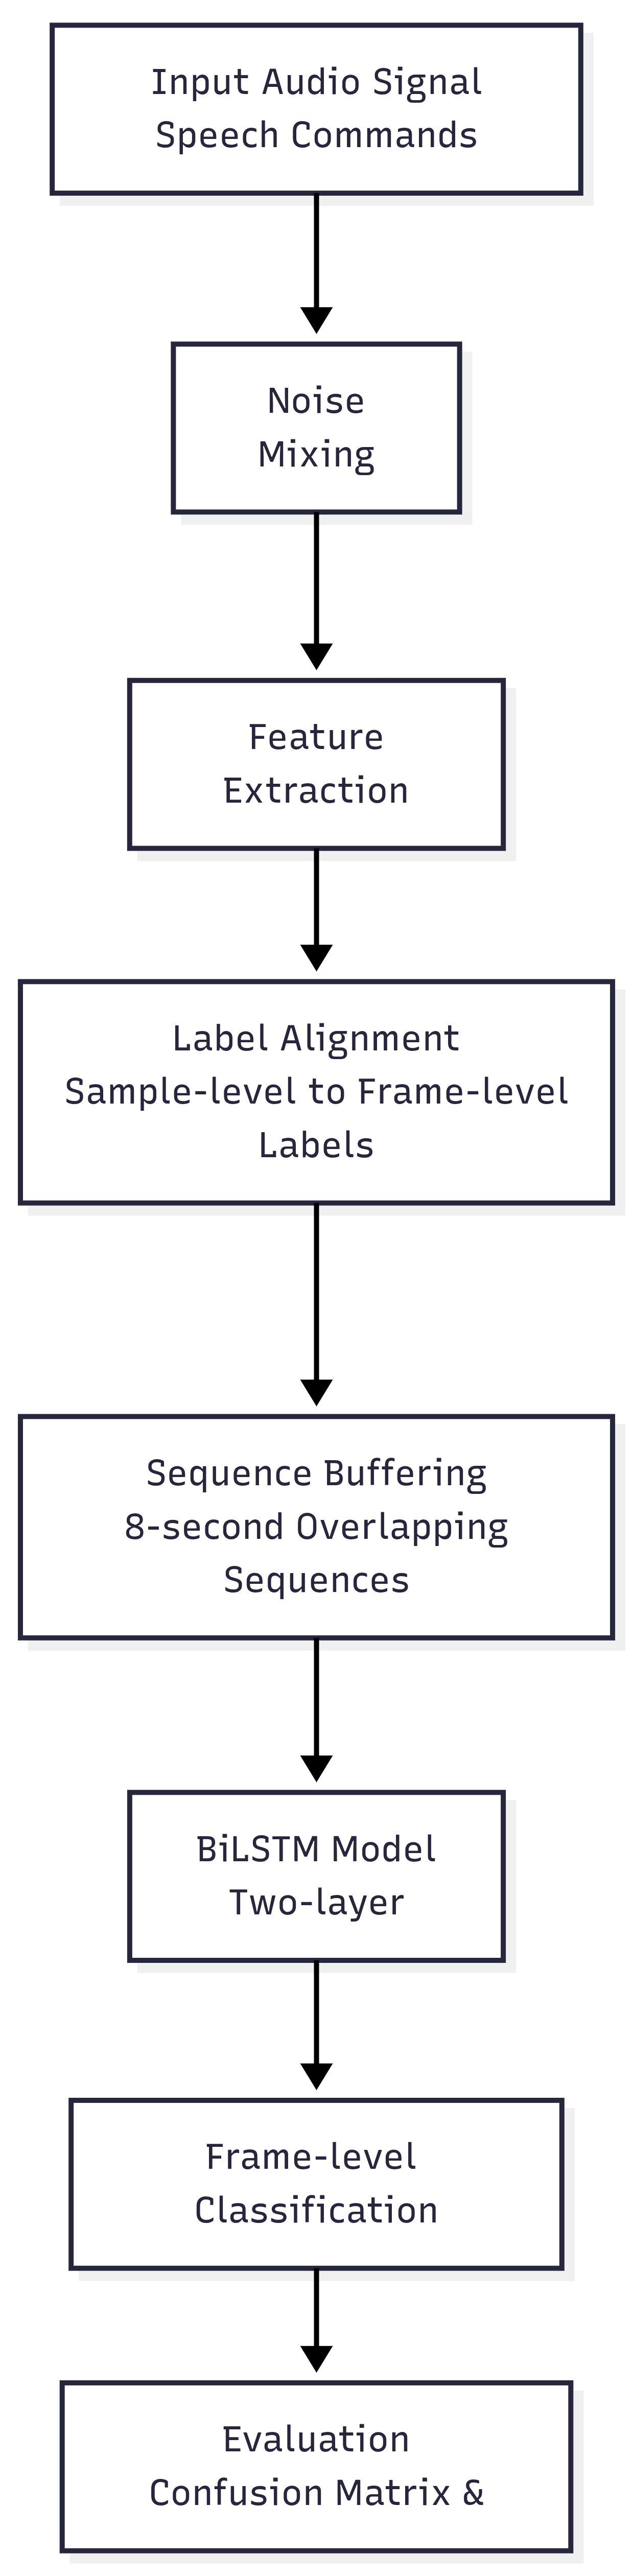

In [26]:
from IPython.display import Image, display

chart_path = "./Charts/chart.png"

display(Image(filename=chart_path))


## Input Data Description

Type of input:
Time-series audio signal (1D waveform)

Source of data:
Google Speech Commands dataset (public and open-licensed)
Available at: https://storage.googleapis.com/download.tensorflow.org/data/speech_commands_v0.01.tar.gz

Audio format:
Mono WAV files
Sample rate: 16 kHz

Ground truth labels:
Binary labels (speech = 1, non-speech = 0)

## Data Preperation and Formatting

Audio files are loaded and converted to mono

Speech signals are normalised to avoid amplitude bias

Background noise is mixed at a fixed SNR level

Long audio signals are constructed by:

Concatenating speech segments

Adding random silence between segments

Ground truth masks are generated to mark speech regions

## Preprocessing Steps

Noise augmentation:
Background noise added to simulate real-world conditions

Feature extraction:
MFCC features extracted using 256-sample window and 128-sample hop

Normalisation:
MFCC features normalised using mean and standard deviation

Frame alignment:
Sample-level labels converted to frame-level using majority voting

Sequence buffering:
Frames grouped into overlapping 8-second sequences for BiLSTM input

## Python Prototype

In [3]:
## Library Imports

import os
import random
import numpy as np
import torch
import torch.nn as nn
import torchaudio
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Reproducibility

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


In [5]:
## Dataset Download and Preparation

import tarfile
import urllib.request

DATA_URL = "https://storage.googleapis.com/download.tensorflow.org/data/speech_commands_v0.01.tar.gz"
DATA_DIR = "speech_commands_v0.01"
TAR_PATH = "speech_commands_v0.01.tar.gz"

if not os.path.exists(DATA_DIR):
    print("Downloading Speech Commands dataset...")
    urllib.request.urlretrieve(DATA_URL, TAR_PATH)

    print("Extracting dataset...")
    with tarfile.open(TAR_PATH, "r:gz") as tar:
        tar.extractall()

    print("Dataset ready.")
else:
    print("Dataset already exists.")


Dataset already exists.


In [6]:
## Dataset Structure

print(os.listdir(DATA_DIR))

['bird', 'LICENSE', 'stop', 'one', 'two', 'wow', 'bed', 'left', 'no', 'README.md', 'house', 'validation_list.txt', 'on', 'five', 'down', 'tree', 'dog', 'four', 'eight', 'seven', 'happy', '_background_noise_', 'sheila', 'marvin', 'three', 'six', 'testing_list.txt', 'go', 'zero', 'up', 'cat', 'nine', 'yes', 'off', 'right']


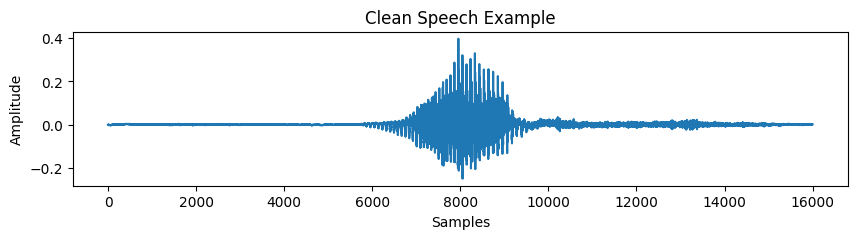

In [7]:
## Load one Clean Speech Sample

sample_path = os.path.join(DATA_DIR, "yes")
sample_file = random.choice(os.listdir(sample_path))

speech, fs = torchaudio.load(os.path.join(sample_path, sample_file))
speech = speech.mean(0)

plt.figure(figsize=(10,2))
plt.plot(speech.numpy())
plt.title("Clean Speech Example")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()


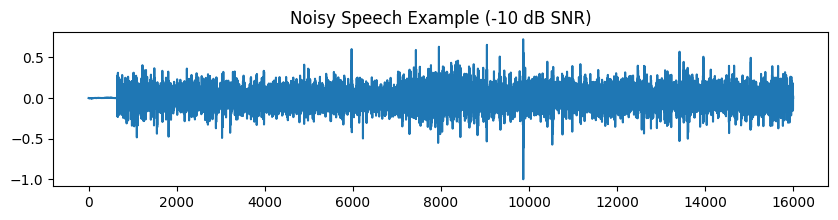

In [8]:
## Load Noise and Apply Low SNR Mixing

noise_path = os.path.join(DATA_DIR, "_background_noise_")
noise_file = random.choice(os.listdir(noise_path))

noise, _ = torchaudio.load(os.path.join(noise_path, noise_file))
noise = noise.mean(0)

def mix_snr(signal, noise, snr_db):
    if noise.numel() < signal.numel():
        repeats = int(np.ceil(signal.numel() / noise.numel()))
        noise = noise.repeat(repeats)

    noise = noise[:signal.numel()]

    signal_norm = torch.norm(signal)
    noise_norm = torch.norm(noise)

    desired_noise_norm = signal_norm / (10 ** (snr_db / 20))
    noise = noise * (desired_noise_norm / noise_norm)

    noisy_signal = signal + noise
    noisy_signal = noisy_signal / noisy_signal.abs().max()

    return noisy_signal

SNR = -10
noisy_speech = mix_snr(speech, noise, SNR)


plt.figure(figsize=(10,2))
plt.plot(noisy_speech.numpy())
plt.title("Noisy Speech Example (-10 dB SNR)")
plt.show()


In [9]:
## Construct Long Training & Validation Signals

def construct_signal(data_dir, fs, duration_sec):
    word_dirs = [
        d for d in os.listdir(data_dir)
        if os.path.isdir(os.path.join(data_dir, d))
        and not d.startswith("_")
    ]

    target_len = duration_sec * fs
    audio = []
    mask = []

    while sum(x.numel() for x in audio) < target_len:
        word = random.choice(word_dirs)
        word_path = os.path.join(data_dir, word)
        wav_file = random.choice(os.listdir(word_path))

        speech, _ = torchaudio.load(os.path.join(word_path, wav_file))
        speech = speech.mean(0)
        speech = speech / speech.abs().max()

        audio.append(speech)
        mask.append(torch.ones_like(speech))

        silence_len = random.randint(int(0.5*fs), int(2*fs))
        audio.append(torch.zeros(silence_len))
        mask.append(torch.zeros(silence_len))

    audio = torch.cat(audio)[:target_len]
    mask = torch.cat(mask)[:target_len]
    return audio, mask

audio_train, mask_train = construct_signal(DATA_DIR, fs, 6000)
audio_val, mask_val     = construct_signal(DATA_DIR, fs, 1200)


In [10]:
## Add Noise to Training & Validation Signals

audio_train = mix_snr(audio_train, noise, -10)
audio_val   = mix_snr(audio_val, noise, -10)


In [11]:
## Feature Extraction

mfcc = torchaudio.transforms.MFCC(
    sample_rate=fs,
    n_mfcc=13,
    melkwargs={
        "n_fft": 256,
        "hop_length": 128
    }
)

X_train = mfcc(audio_train)
X_val   = mfcc(audio_val)


mean = X_train.mean(dim=1, keepdim=True)
std  = X_train.std(dim=1, keepdim=True)

X_train = (X_train - mean) / (std + 1e-8)
X_val   = (X_val   - mean) / (std + 1e-8)


/home/hasith/Personal/vad/.venv/lib/python3.13/site-packages/torchaudio/functional/functional.py:582: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (129) may be set too low.
  warnings.warn(


In [12]:
## Frame-Level Label Alignment

def frame_labels(sample_mask, frame_len=256, hop_len=128):
    frames = sample_mask.unfold(0, frame_len, hop_len)
    return frames.mode(dim=1).values

y_train = frame_labels(mask_train)
y_val   = frame_labels(mask_val)


In [13]:
## Sequence Buffering

def buffer_sequences(X, y, seq_len):
    X_seq, y_seq = [], []
    hop = int(seq_len * 0.25)

    max_len = min(X.shape[1], y.shape[0])

    for i in range(0, max_len - seq_len, hop):
        x_chunk = X[:, i:i+seq_len].transpose(0, 1)
        y_chunk = y[i:i+seq_len]

        # Safety check
        if x_chunk.shape[0] == y_chunk.shape[0]:
            X_seq.append(x_chunk)
            y_seq.append(y_chunk)

    return X_seq, y_seq


In [14]:
seq_len = int(8 * fs / 128)

X_train_seq, y_train_seq = buffer_sequences(X_train, y_train, seq_len)
X_val_seq,   y_val_seq   = buffer_sequences(X_val,   y_val,   seq_len)


print("One training sequence shape:", X_train_seq[0].shape)
print("One label sequence shape:", y_train_seq[0].shape)


One training sequence shape: torch.Size([1000, 13])
One label sequence shape: torch.Size([1000])


Network Architecture

Long Short-Term Memory (LSTM) networks are well suited for sequence modelling tasks due to their
ability to learn long-term temporal dependencies. In this prototype, a Bidirectional LSTM (BiLSTM)
network is used to model both past and future context within an audio sequence, which is important
for accurate voice activity detection.

The network consists of two stacked BiLSTM layers followed by a fully connected output layer that
predicts speech and non-speech classes for each time frame.


In [15]:
class VADBiLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=2):
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )

        self.fc = nn.Linear(hidden_dim * 2, 2)  # 2 classes: speech / non-speech

    def forward(self, x):
        # x: [batch, time, features]
        out, _ = self.lstm(x)
        out = self.fc(out)
        return out


In [16]:
## Model Initialization

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VADBiLSTM(input_dim=13).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print(model)

VADBiLSTM(
  (lstm): LSTM(13, 128, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


In [17]:
## Training Setup

def to_tensor(seq_list, dtype):
    return [torch.tensor(x, dtype=dtype) for x in seq_list]


X_train_seq = to_tensor(X_train_seq, torch.float32)
y_train_seq = to_tensor(y_train_seq, torch.long)

X_val_seq   = to_tensor(X_val_seq, torch.float32)
y_val_seq   = to_tensor(y_val_seq, torch.long)



/tmp/ipykernel_210216/1606703382.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return [torch.tensor(x, dtype=dtype) for x in seq_list]


Model Training

The model is trained using the Adam optimiser and cross-entropy loss.
Training is performed on overlapping 8-second audio sequences.
The loss is computed at the frame level to enable fine-grained voice activity detection.


In [18]:
## Training Loop

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for X_seq, y_seq in zip(X_train_seq, y_train_seq):
        X_seq = X_seq.unsqueeze(0).to(device)      # [1, time, features]
        y_seq = y_seq.unsqueeze(0).to(device)      # [1, time]

        optimizer.zero_grad()

        outputs = model(X_seq)

        T = min(outputs.shape[1], y_seq.shape[1])
        outputs = outputs[:, :T, :]
        y_seq = y_seq[:, :T]

        loss = criterion(
            outputs.reshape(-1, 2),
            y_seq.reshape(-1)
        )

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(X_train_seq)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Training Loss: {avg_loss:.4f}")


Epoch [1/10] - Training Loss: 0.3599
Epoch [2/10] - Training Loss: 0.3296
Epoch [3/10] - Training Loss: 0.3172
Epoch [4/10] - Training Loss: 0.3117
Epoch [5/10] - Training Loss: 0.3050
Epoch [6/10] - Training Loss: 0.2982
Epoch [7/10] - Training Loss: 0.2921
Epoch [8/10] - Training Loss: 0.2858
Epoch [9/10] - Training Loss: 0.2764
Epoch [10/10] - Training Loss: 0.2725


Validation

After training, the model is evaluated on unseen validation data.
Predictions are generated at the frame level and compared against the
ground truth labels.

In [19]:
## Inference

model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for X_seq, y_seq in zip(X_val_seq, y_val_seq):
        X_seq = X_seq.unsqueeze(0).to(device)

        outputs = model(X_seq)

        T = min(outputs.shape[1], y_seq.shape[0])
        outputs = outputs[:, :T, :]
        y_seq = y_seq[:T]

        preds = torch.argmax(outputs, dim=-1).cpu().view(-1)

        all_preds.append(preds)
        all_targets.append(y_seq.view(-1))

all_preds = torch.cat(all_preds)
all_targets = torch.cat(all_targets)



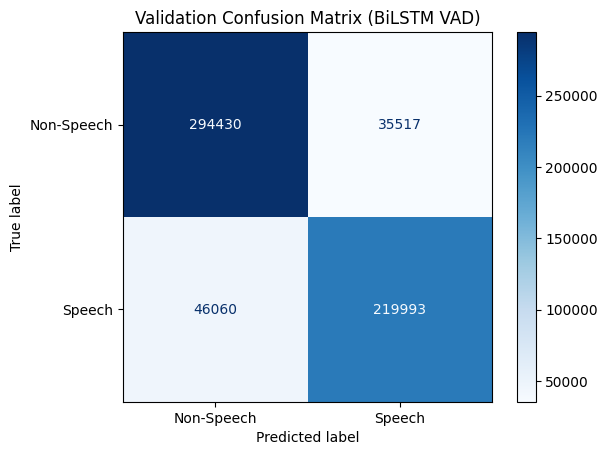

In [20]:
## Confusion Matrix 

cm = confusion_matrix(all_targets, all_preds)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Non-Speech", "Speech"]
)

disp.plot(cmap="Blues")
plt.title("Validation Confusion Matrix (BiLSTM VAD)")
plt.show()


In [21]:
## Evaluation Matrics 

TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

accuracy  = (TP + TN) / cm.sum()
precision = TP / (TP + FP + 1e-8)
recall    = TP / (TP + FN + 1e-8)
f1        = 2 * precision * recall / (precision + recall + 1e-8)

print(f"Accuracy : {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall   : {recall:.3f}")
print(f"F1 Score : {f1:.3f}")


Accuracy : 0.863
Precision: 0.861
Recall   : 0.827
F1 Score : 0.844


### Part D - Software Testing and Evaluation

## Verification of Correctness and Testing Methodalogy

To verify the correctness of the Voice Activity Detection (VAD) implementation, a supervised evaluation strategy was adopted. The trained BiLSTM model was tested on a held-out validation dataset that was not used during training. This ensures that the evaluation measures the model’s ability to generalise to unseen audio rather than memorising the training data.

The testing methodology follows standard practices in speech processing and machine learning:

Frame-level classification testing was performed, where each MFCC frame was classified as either speech or non speech.

Ground truth labels were derived from sample level annotations and aligned to MFCC frames using majority voting, ensuring temporal consistency between features and labels.

A confusion matrix was computed to compare expected (ground truth) labels against predicted labels.

The confusion matrix allows direct inspection of:

True Positives (TP): correctly detected speech frames

True Negatives (TN): correctly detected non-speech frames

False Positives (FP): non-speech incorrectly detected as speech

False Negatives (FN): speech incorrectly classified as non-speech


## Performance Evaluation and Effectiveness

The following results were obtained on the validation dataset:

Accuracy: 0.863  

Precision: 0.861

Recall: 0.827

F1 Score: 0.844

Interpretation of Metrics

Accuracy (86.3%) indicates that the model correctly classified the majority of audio frames. However, in voice activity detection tasks, accuracy alone can be misleading due to the natural imbalance between speech and non-speech frames.

Precision (86.1%) shows that when the model predicts speech, it is correct most of the time. This is important for applications where false speech detection (e.g., triggering a voice assistant unnecessarily) should be minimised.

Recall (82.7%) reflects the model’s ability to detect actual speech frames. A high recall is crucial in speech-driven systems, as missed speech can degrade user experience or downstream speech recognition performance.

F1 Score (84.4%), which balances precision and recall, indicates that the model provides a robust trade-off between avoiding false alarms and detecting true speech.

## Interpretation of Results, Insights, Strengths and Limitations

The results show that the proposed Voice Activity Detection (VAD) system performs well on a widely used public dataset. The achieved accuracy, precision, recall, and F1 score indicate that the BiLSTM model can reliably distinguish speech and non-speech frames in noisy conditions. This suggests that the model has learned temporal speech patterns such as speech continuity and pauses, rather than relying only on signal energy.

This is important in the speech processing domain because real speech is continuous over time. The combination of MFCC features and a BiLSTM enables the model to capture these temporal dependencies, which explains the good performance on the Speech Commands dataset. Since this dataset is commonly used by both researchers and industry, the results follow industry-accepted practices.

However, real-world noise conditions are much more diverse than those present in the dataset. Environmental noises such as traffic, crowds, and machinery can vary significantly, and model performance may degrade in unseen conditions. This highlights the importance of dataset diversity for robustness. Future improvements could include training with more environmental noise data and using hybrid approaches, such as combining deep learning-based VAD with energy-based methods or pretrained models like Silero VAD and speaker-aware techniques similar to pyannote.

Strengths:

The model demonstrates strong performance on a popular and widely accepted benchmark dataset.

The BiLSTM architecture effectively learns temporal speech patterns rather than relying on simple thresholds.

The implementation is based on PyTorch, which is widely used in industry.

The model can be easily converted and deployed using platforms such as ONNX or TensorRT, enabling optimisation for real-time and embedded systems.

Limitations:

The training and evaluation data represent a limited range of noise environments.

The evaluation is frame-based rather than event-based, which may affect real-world segmentation quality.

The model has not been explicitly optimised for streaming or ultra-low-latency deployment.


Overall, the results demonstrate that the system is effective within the scope of the dataset and task, while also highlighting clear directions for improving robustness and real-world applicability.

### Part E - Equity, Diversity, Inclusion (EDI) and Sustainability

## Equity, Diversity, Inclusion and Ethics

The proposed Voice Activity Detection system does not make decisions based on gender, ethnicity, race, accent, or speaker identity. The model only detects the presence or absence of speech, not who is speaking, which reduces the risk of demographic bias. The implementation uses a publicly available and widely used dataset, the Google Speech Commands dataset, which is openly licensed and commonly used in both academic and industry research.

Because the dataset is open and well-documented, it supports transparency and reproducibility. The model does not perform speaker profiling or content analysis, so there are no direct ethical risks related to privacy or discrimination. This makes the system suitable for general speech-processing tasks such as preprocessing for ASR or robotics.


## Environmental Sustainability

The model was trained using a laptop-grade NVIDIA RTX 4050 GPU, with only 10 training epochs, which keeps computational cost relatively low. The dataset size is approximately 2 GB, which is reasonable in terms of data storage requirements. This shows that the system can be developed without large-scale data centres or excessive energy consumption.

In real-world deployment, this type of model is often used in embedded and robotics systems. Lightweight versions of the model can run on single-board computers such as Toradex or microcontroller-based platforms. For higher performance requirements, NVIDIA Jetson devices (such as Jetson Nano or Orin) can be used, which typically operate around 10–15 W, making them energy efficient compared to desktop GPUs.

Using widely adopted platforms like NVIDIA Jetson also improves software compatibility, long-term support, and stability, which reduces redevelopment costs and environmental impact. Further optimisation using ONNX or TensorRT could reduce power consumption even more in production deployment.

## References

Warden, P. (2017) Speech Commands: A public dataset for single-word speech recognition. Available at: https://storage.googleapis.com/download.tensorflow.org/data/speech_commands_v0.01.tar.gz

Warden, P. (2017) ‘Speech Commands: A public dataset for single-word speech recognition’, arXiv preprint, arXiv:1703.05390. Available at: https://arxiv.org/abs/1703.05390